# RL4CRN tutorial notebook: Logic Circuit Inference Task (CVODE)

This notebook shows an end-to-end **RL4CRN** workflow:

1. **Import utilities** and choose a **configuration preset**
2. **Build a template IO-CRN** (species, input/output mapping, solver settings)
3. **Build a reaction library** (MAK library in this example)
4. **Define a task** (here: *Logic Circuit Inference* objective) using the **new TaskKind interface**
5. **Configure training**
6. **Create a session + trainer** and run training
7. **Inspect the best CRN** from the Hall of Fame
8. **Sample and re-simulate** under new conditions
9. **Save/load** checkpoints

> Tip: If you ever see shape-related errors (e.g., ragged arrays), print and validate  
> `template_crn.num_inputs` vs `len(u_list[0])` to ensure input dimension consistency.


In [1]:
import os, sys, numpy as np

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())


Python: 3.10.12
CWD: /local0/rossin/git/CRN-GenerativeAI/apps


## 1) Import RL4CRN helpers

We use the user-facing interface utilities from `RL4CRN.utils.input_interface`:

- `Configurator`: provides presets and override helpers
- `make_task`: builds a `TaskSpec` with reward function and input scenarios
- `make_session_and_trainer`: wires up environments, interfaces, policy, and agent
- `print_task_summary`: quick diagnostic summary for the created task

**New interface note:** task-kind-specific knobs can now also be passed through a `params` dict
(or `**kwargs`) inside the new task-kind implementation. For backward compatibility, passing
`logic_fn=...` directly is still supported in the public `make_task`.


In [2]:
from RL4CRN.utils.input_interface import (
    Configurator,
    make_task,
    make_session_and_trainer,
    print_task_summary,
)
from RL4CRN.utils.default_tasks.LogicTaskKind import LogicTaskKind


## 2) Build a template IO/CRN

A **template IO-CRN** defines:
- the **species** in the model
- how **inputs** enter the system (via `input_map`)
- how **dilution** (if any) is applied
- which species is treated as the **output**
- the **ODE solver** and its tolerances

Here we use the convenience builder `build_logic_IOCRN`, which provides an easy way to construct a CRN with digital inputs and a single output node.


In [3]:
from RL4CRN.utils.crn_builders import build_logic_IOCRN

# choose preset
cfg = Configurator.preset("paper")

# select simulator and set tolerances
cfg.solver.algorithm = "CVODE"
cfg.solver.rtol = 1e-10
cfg.solver.atol = 1e-10

# build template IO/CRN
n_inputs = 3
species_labels = ['X_1', 'X_2', 'X_3']
crn, species_labels = build_logic_IOCRN(
    n_inputs=n_inputs,
    include_dilution=False,
    solver=cfg.solver,
)

print("Template CRN built.")
print(" - num_inputs:", crn.num_inputs)
print(" - num_species:", len(species_labels))
print(" - species:", species_labels)


Template CRN built.
 - num_inputs: 3
 - num_species: 4
 - species: ['X_1', 'X_2', 'X_3', 'OUT']


## 3) Build the reaction library (MAK)

RL4CRN typically proposes reactions from a **library**.  
This example uses a MAK library of given order (here `order=2`).

The builder returns a tuple `(library, M, K, masks)` that the training pipeline needs.


In [4]:
from RL4CRN.utils.library_builders import build_MAK_library

# library components
library_components = build_MAK_library(crn, species_labels, order=2)

library, M, K, masks = library_components
print("Library built.")
print(" - M (num reactions in library):", M)
print(" - K (num parameters in library):", K)


Library built.
 - M (num reactions in library): 211
 - K (num parameters in library): 211


## 4) Define the task: Logic Circuit Inference

We define a **Logic Circuit Inference** task.

- `kind="logic"` selects the logic-task reward handler (via the new task-kind registry).
- The system automatically generates the truth table input scenarios for the chosen number of inputs.
- `n_inputs` must match `template_crn.num_inputs`.
- `ic=("constant", 0.01)` sets initial concentrations.
- We specify the target logic function (`logic_fn`) as

$$
f_{\text{LOGIC}}(\mathbf{X}) = X_1 \land X_2 \land X_3,
$$

in this example.


In [5]:
LogicTaskKind.pretty_help()

### TaskKind `logic`

**Required params**
- `logic_fn`: Callable[[np.ndarray], bool] (truth table target)

**Optional params**
- `n_inputs`: int (defaults to template_crn.num_inputs)
- `t_f`: float (default 100.0)
- `n_t`: int (default 1000)
- `ic`: IC spec, e.g. ('constant', 0.01) or 'zero'
- `weights`: weights spec, e.g. 'transient' | 'uniform' | 'steady_state' | ('custom', array)
- `u_list`: explicit list of inputs (overrides defaults)
- `u_spec`: ('custom'| 'grid'| 'linspace', ...) escape hatch
- `norm`: int (default 1)
- `LARGE_NUMBER`: float (default 1e4)

**Notes**
- If neither u_list nor u_spec is provided, defaults to full truth-table grid over {0,1}^n_inputs.


In [6]:
logic_fn = lambda x: all(x)  # AND logic (X_1 AND X_2 AND X_3)

task = make_task(
    template_crn=crn,
    library_components=library_components,
    kind="logic",
    species_labels=species_labels,
    params={
        "n_inputs": n_inputs,
        "t_f": 100,
        "n_t": 1000,
        "ic": ("constant", 0.01),
        "weights": "transient",
        "logic_fn": logic_fn,
        # optionally "u_spec": ("grid", [0.0, 1.0]) or "u_list": [...]
    }
)

print_task_summary(task)

# --- Optional safety checks (recommended) ---
print("Sanity checks:")
print(" - template num_inputs:", crn.num_inputs)
print(" - first u shape:", np.asarray(task.u_list[0]).shape)
print(" - first u length:", len(task.u_list[0]))
assert len(task.u_list[0]) == crn.num_inputs, "Input dimension mismatch: u has wrong length!"


Task: logic
time_horizon: (1000,) [0..100.0]
num scenarios: 8
first 3 u: [array([0., 0., 0.], dtype=float32), array([0., 0., 1.], dtype=float32), array([0., 1., 0.], dtype=float32)]

Sanity checks:
 - template num_inputs: 3
 - first u shape: (3,)
 - first u length: 3


## 5) Training configuration

We tune:
- `max_added_reactions`: episode length (how many reactions the agent can add)
- `epochs`: training iterations
- `render_every`: print progress cadence
- `seed`: reproducibility


In [7]:
# ---- Train config ----
cfg.train.max_added_reactions = 5
cfg.train.epochs = 5
cfg.train.render_every = 5
cfg.train.seed = 0


In [8]:
cfg.render.n_best = 50
cfg.render.disregarded_percentage = 0.9
cfg.render.mode = {  # Mode of the experiment
    'style': 'logger', 
    'task': 'transients + logic', 
    'format': 'image',
    'topology': True
}

## 6) Inspect full configuration (optional)

`cfg.describe()` prints a nested configuration dictionary.


In [9]:
cfg.describe()

{'task': None,
 'solver': {'algorithm': 'CVODE', 'rtol': 1e-10, 'atol': 1e-10},
 'train': {'epochs': 5,
           'max_added_reactions': 5,
           'render_every': 5,
           'hall_of_fame_size': 50,
           'batch_multiplier': 10,
           'seed': 0,
           'n_cpus': None,
           'batch_size': None},
 'policy': {'width': 1024,
            'depth': 5,
            'deep_layer_size': 10240,
            'continuous_distribution': {'type': 'lognormal_1D'},
            'entropy_weights_per_head': {'structure': 2.0, 'continuous': 1.0, 'discrete': 0.0, 'input_influence': 0.0},
            'ordering_enabled': False,
            'constraint_strength': inf},
 'agent': {'learning_rate': 0.0001,
           'entropy_scheduler': {'entropy_weight': 0.001,
                                 'topk_entropy_weight': 1.0,
                                 'remainder_entropy_weight': 1.0,
                                 'entropy_update_coefficient': 1,
                                 'en

## 7) Create session + trainer

This step wires together:
- parallel environments
- observer/tensorizer/actuator/stepper interfaces
- policy + agent
- the chosen task reward function

The returned object:
- `trainer`: runs rollout → reward eval → policy update loops


In [10]:
import os
from datetime import datetime
from pytorch_lightning.loggers import CometLogger

task_name = "RPA_Task"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Expect these in your environment:
#   COMET_API_KEY   (required)
#   COMET_WORKSPACE (required)
api_key = os.environ["COMET_API_KEY"]
workspace = os.environ["COMET_WORKSPACE"]

logger = CometLogger(
    api_key=api_key,
    project=task_name,
    workspace=workspace,
    name=f"{task_name}_{timestamp}",
)

logger = logger.experiment

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/redsnic/rpa-task/5a726f92fc5044a8b0022a46e7f42702



In [11]:
trainer = make_session_and_trainer(cfg, task, logger=logger)

## 8) Train and save checkpoints

We run for `cfg.train.epochs` epochs and periodically save a checkpoint.



[cvHandleFailure, Error: -15] At t = 12.4015418041778, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 15.210402607717, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 24.0707965204955, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 17.7373537714688, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 14.019529677421, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 10.6044797656618, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 7.27959634632382, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.9981032240773, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 26.1345221797166, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.7458424313108, unable to satisfy inequality constraints.


[cvHandleFa

/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:386: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.95])
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))
/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/environments/environment.py:386: UserWarning: The figure layout has changed 

Saved checkpoint: logic_task_chkpt.pkl

[cvHandleFailure, Error: -15] At t = 41.8006213529757, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 15.0215010973392, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 15.4107495552583, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 7.76664591075183, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 5.5816231459374, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 29.3019501139213, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 11.8843220931663, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 7.39677550953829, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 16.6915993413888, unable to satisfy inequality constraints.


[cvHandleFailure, Error: -15] At t = 23.6853160036396, unable to satis

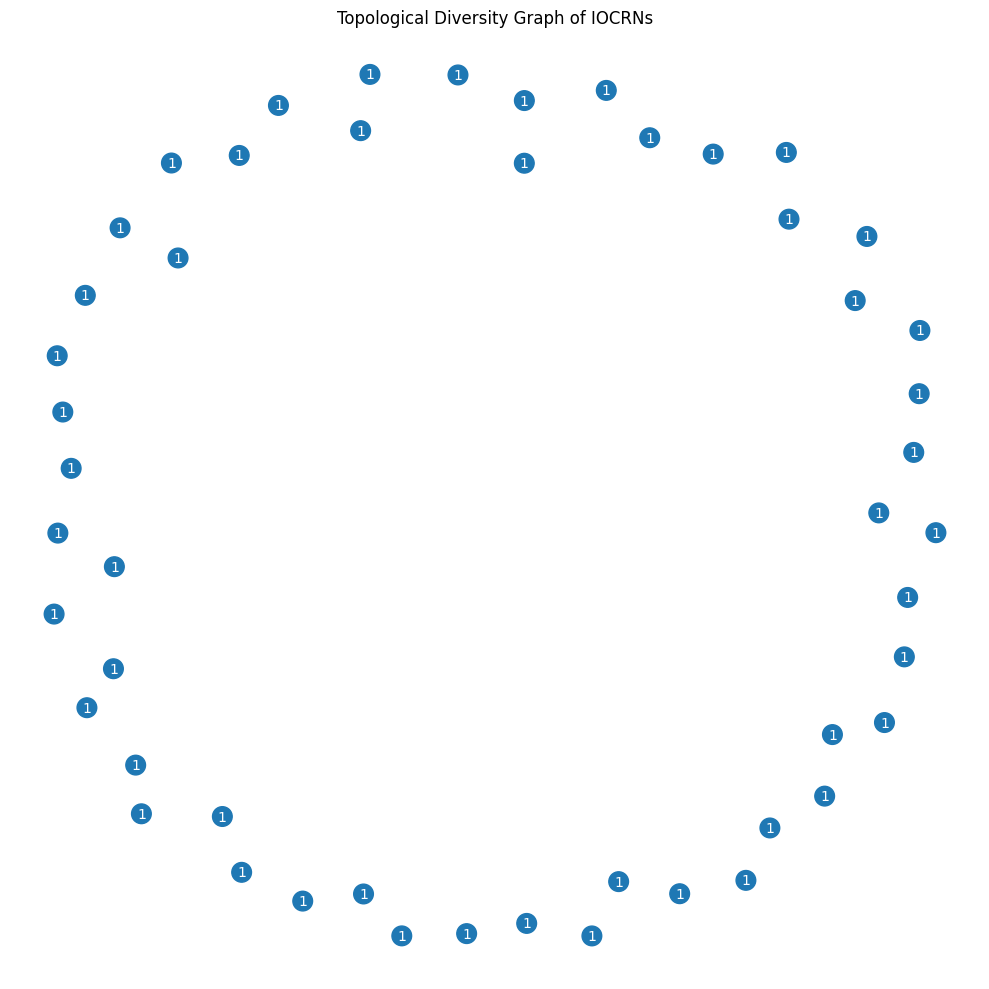

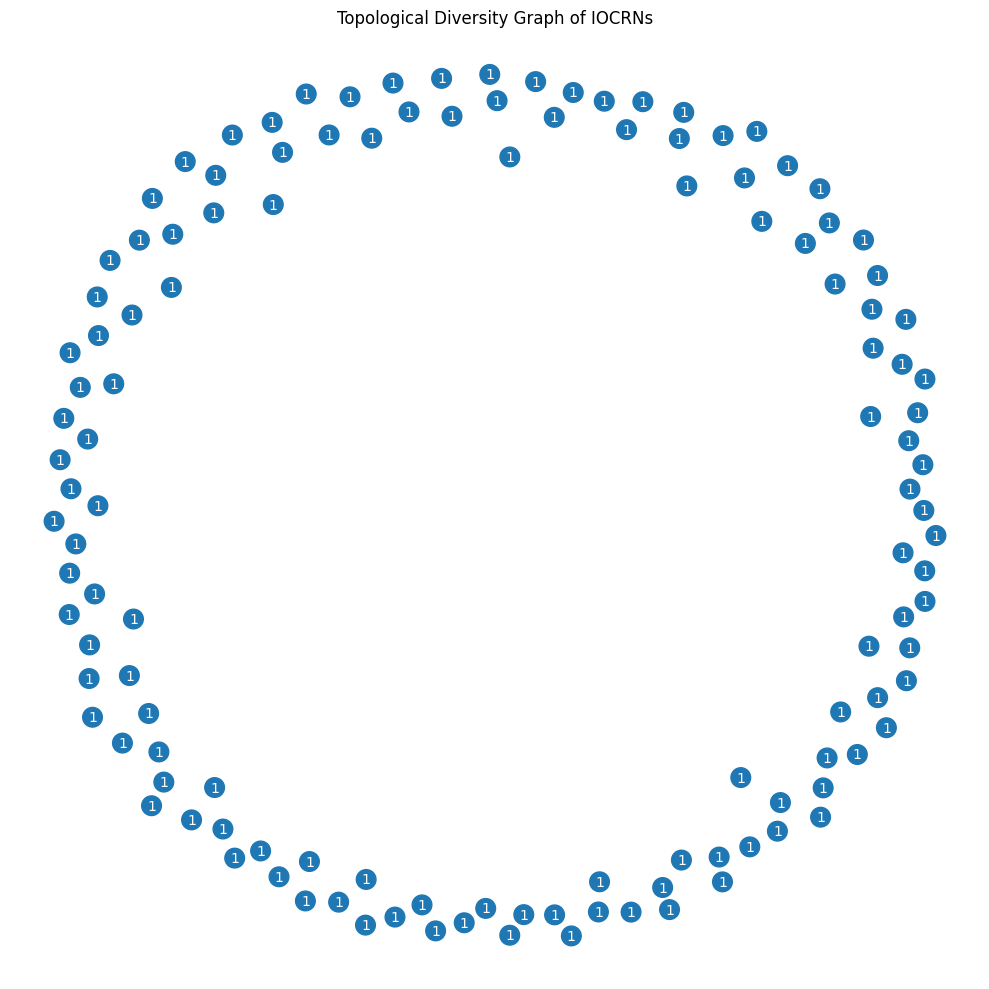

In [12]:
checkpoint_path = "logic_task_chkpt.pkl"
trainer.run(epochs=cfg.train.epochs, checkpoint_path=checkpoint_path)


## 9) Inspect the best CRN

The trainer keeps a **Hall of Fame** of good CRNs found during rollouts.


Best CRN loss: 0.07397101511929192
Inputs: ['u_1', 'u_2', 'u_3'] 
Species: ['OUT', 'X_1', 'X_2', 'X_3'] 
Output Species: ['OUT'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(1.0, u_2)]
∅ ----> X_3;  [MAK(1.0, u_3)]
X_1 + X_2 ----> OUT;  [MAK(0.7659051418304443)]
X_1 + X_3 ----> ∅;  [MAK(0.7443163990974426)]
OUT + X_1 ----> X_1;  [MAK(0.9148674011230469)]
OUT + OUT ----> X_1;  [MAK(0.19083279371261597)]
OUT + OUT ----> X_1 + X_1;  [MAK(0.7699247002601624)]


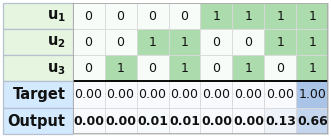

Hall of Fame size: 50
Best loss: 0.07397101511929192


In [13]:
trainer.inspect_best(plot=True)

best = trainer.best_crn()
print("Hall of Fame size:", len(trainer.s.mult_env.hall_of_fame))
if best is not None:
    print("Best loss:", best.last_task_info.get("reward", None))


## 10) Sample and re-simulate

After training, we can **draw new CRN designs from the learned policy** (sampling runs in evaluation mode, i.e., no gradient updates) and **re-evaluate** them.

This is useful for:
- **Model exploration:** quickly inspect diverse candidates generated by the policy.
- **Controlled re-simulation:** re-run sampled CRNs under modified conditions (`u_list/u_spec`, `ic`, etc.).

Sampling produces a dedicated **sample Hall-of-Fame** that stores the best `K` sampled environments (lowest loss) for later inspection and checkpointing.


In [14]:
trainer.sample(10, 10, ic=("constant", 1.0))


[cvHandleFailure, Error: -15] At t = 15.6709343884886, unable to satisfy inequality constraints.



We can now inspect newly sampled I/O CRNs.

Inputs: ['u_1', 'u_2', 'u_3'] 
Species: ['OUT', 'X_1', 'X_2', 'X_3'] 
Output Species: ['OUT'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(1.0, u_2)]
∅ ----> X_3;  [MAK(1.0, u_3)]
X_2 ----> X_1 + X_1;  [MAK(0.36989137530326843)]
X_2 ----> X_1 + X_2;  [MAK(0.9910580515861511)]
OUT + X_1 ----> X_2 + X_3;  [MAK(2.084353446960449)]
X_2 + X_2 ----> X_3 + X_3;  [MAK(0.10925517231225967)]
OUT + OUT ----> X_1 + X_3;  [MAK(0.750889241695404)]
reward: 0.13187226139648894


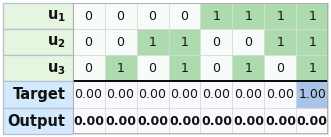

/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))


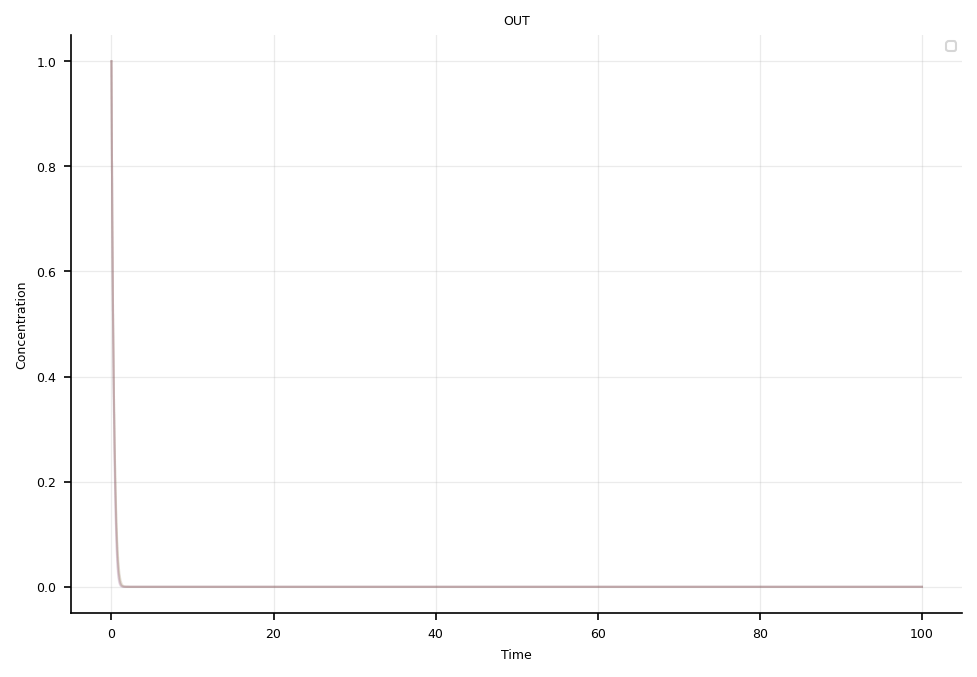

In [15]:
import matplotlib.pyplot as plt

index = 0
crn_s = trainer.get_sampled_crns()[index]
print(crn_s)
print("reward:", crn_s.last_task_info.get("reward", None))

# Plotters depend on your IOCRN implementation
crn_s.plot_logic_response(); plt.show()
crn_s.plot_transient_response(); plt.show()

Save again our results.

In [16]:
trainer.save(checkpoint_path)

Saved checkpoint: logic_task_chkpt.pkl


## 11) Loading a saved Session/Trainer from a checkpoint

`load_session_and_trainer` reconstructs wiring and restores weights, history, HoFs, and RNG states.


Best CRN loss: 0.07397101511929192
Inputs: ['u_1', 'u_2', 'u_3'] 
Species: ['OUT', 'X_1', 'X_2', 'X_3'] 
Output Species: ['OUT'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(1.0, u_2)]
∅ ----> X_3;  [MAK(1.0, u_3)]
X_1 + X_2 ----> OUT;  [MAK(0.7659051418304443)]
X_1 + X_3 ----> ∅;  [MAK(0.7443163990974426)]
OUT + X_1 ----> X_1;  [MAK(0.9148674011230469)]
OUT + OUT ----> X_1;  [MAK(0.19083279371261597)]
OUT + OUT ----> X_1 + X_1;  [MAK(0.7699247002601624)]


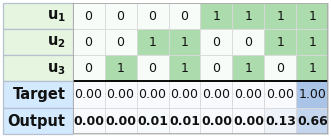

In [17]:
from RL4CRN.utils.input_interface import load_session_and_trainer

trainer_loaded = load_session_and_trainer(checkpoint_path, device="cuda")
trainer_loaded.inspect_best()

## 12) Re-simulate Hall-of-Fame CRNs under new conditions

We can take the training Hall-of-Fame CRNs and re-simulate them under a new IC and/or new input set.

This uses `Trainer.resimulate(...)` which clones CRNs before evaluation (so old results remain intact).



[cvHandleFailure, Error: -15] At t = 6.18521012926981, unable to satisfy inequality constraints.

CRN loss: 0.08777598964792688
Inputs: ['u_1', 'u_2', 'u_3'] 
Species: ['OUT', 'X_1', 'X_2', 'X_3'] 
Output Species: ['OUT'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_2;  [MAK(1.0, u_2)]
∅ ----> X_3;  [MAK(1.0, u_3)]
X_1 + X_2 ----> OUT;  [MAK(0.7659051418304443)]
X_1 + X_3 ----> ∅;  [MAK(0.7443163990974426)]
OUT + X_1 ----> X_1;  [MAK(0.9148674011230469)]
OUT + OUT ----> X_1;  [MAK(0.19083279371261597)]
OUT + OUT ----> X_1 + X_1;  [MAK(0.7699247002601624)]


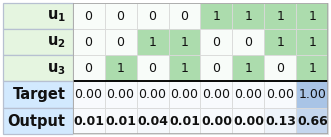

/local0/rossin/git/CRN-GenerativeAI/.venv/lib/python3.10/site-packages/RL4CRN/utils/plotting_style.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(**cfg.get("legend_kwargs", {}))


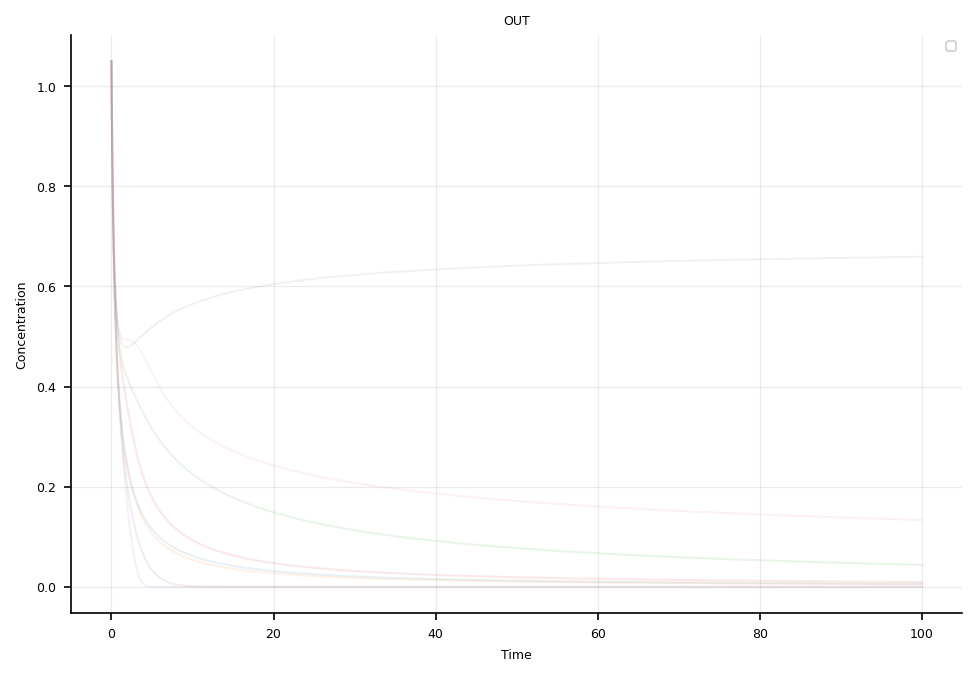

In [18]:
hof_crns = [item.state for item in trainer.s.mult_env.hall_of_fame]

trainer.s.crn_template

crns_new = trainer.resimulate(
    hof_crns,
    ic=("constant", 1.05), 
    u_spec=("grid", [0.0, 1.0]),
)

trainer.inspect(crns_new[0])
crns_new[0].plot_transient_response(); plt.show()